In [16]:
from zipfile import ZipFile
import torchvision
import os
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# # specifying the zip file name
# file_name = "underwater_sem_seg.zip"
# #
# # # opening the zip file in READ mode
# with ZipFile(file_name, 'r') as zip:
#     # printing all the contents of the zip file
#     zip.printdir()

#     # extracting all the files
#     print('Extracting all the files now...')
#     zip.extractall()
#     print('Done!')


In [3]:
# pip install torchvision

In [4]:
# os.listdir("underwater_sem_seg/dataset")

In [5]:
root = "dataset"

entries = os.listdir(root)
entries.remove("indices_files")
entries.remove('.DS_Store')
print(entries)
folders = [root+"/"+i for i in entries[1:]]
print(folders)
# entries = os.listdir(folders[0])
# print(entries)
images = []
masks = []
imclasses = []
for folder in folders:
    entries = os.listdir(folder)
    for image_data in entries:
#         print(folder+"/"+image_data)
        mat = loadmat(folder+"/"+image_data)
        # print(mat)
        images.append(np.asarray(mat["image_array"]))
        imclasses.append(mat["class"])
        masks.append(np.asarray(mat["mask_array"]))
        # images.append((imclass,image,mask_array))
    # break

print(len(images))
print(images[0].shape)


['dolphin_sem_seg_gt', 'crocodile_sem_seg_gt', 'seal_sem_seg_gt', 'sea_anemone_sem_seg_gt', 'squid_sem_seg_gt', 'turtle_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'penguin_sem_seg_gt', 'whale_sem_seg_gt', 'frog_sem_seg_gt', 'crab_sem_seg_gt', 'otter_sem_seg_gt', 'nettles_sem_seg_gt', 'shark_sem_seg_gt', 'polar_bear_sem_seg_gt', 'shrimp_sem_seg_gt', 'star_fish_sem_seg_gt', 'octopus_sem_seg_gt', 'seahorse_sem_seg_gt', 'stingray_sem_seg_gt', 'nudibranch_sem_seg_gt']
['dataset/crocodile_sem_seg_gt', 'dataset/seal_sem_seg_gt', 'dataset/sea_anemone_sem_seg_gt', 'dataset/squid_sem_seg_gt', 'dataset/turtle_sem_seg_gt', 'dataset/sea_urchin_sem_seg_gt', 'dataset/penguin_sem_seg_gt', 'dataset/whale_sem_seg_gt', 'dataset/frog_sem_seg_gt', 'dataset/crab_sem_seg_gt', 'dataset/otter_sem_seg_gt', 'dataset/nettles_sem_seg_gt', 'dataset/shark_sem_seg_gt', 'dataset/polar_bear_sem_seg_gt', 'dataset/shrimp_sem_seg_gt', 'dataset/star_fish_sem_seg_gt', 'dataset/octopus_sem_seg_gt', 'dataset/seahorse_sem_seg_gt', 

In [6]:

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1)

for train_index, test_index in split.split(images,imclasses):
    print(train_index,test_index)
    images_train = [images[i] for i in train_index]
    classes_train = [imclasses[i] for i in train_index]
    masks_train = [masks[i] for i in train_index]

    images_test = [images[i] for i in test_index]
    classes_test = [imclasses[i] for i in test_index]
    masks_test = [masks[i] for i in test_index]

print(len(images_train),len(images_test))

print(classes_train)
print(classes_test)

[239 132 498 167 198 147  75  42 310  77  46 452 377   5  76 212 207 327
 216 173 525 168 456 106 382 172 264 467 252 245 401 362 436 428 238  12
 371 295 126 100   9 483 300 373 331 309 383 236 503 519 347 136  81 351
 274  61 332 352 412 200 258 337 187 299 291 493 439 495 284 279 162 145
 330 133 321 532  20 434 390 505 208 257  29 192  72 153  88  79 157 447
  95 513 464 181 437 536 289 408 342 215  82  97  68 250 453 266 308 422
 480  58 312 344 163 221 165 127 288 267 396  11 405 211  17 114 445 217
 501 230 354 286 459  32 171 520  24 487  57 158 462  86 441  13 335 494
 278 323  30  87 326  50 222 255  78 249 397 365 262 241  14 370 508   6
 472  67 280  93 231 218 268 387 484 195 395 398  55 148 353 540 334 170
 164 491 234 380 107 486   8 199 416  21 209 415 185  45 319 138 213 253
 111 502 260 512   0 290 507 414 421 515 443 497 150  64  18 500 374 359
 349  41 438 233  73 407 285 142 460 430 235 343 131 130 109  35 124 541
 528 322 471  62  10 488 314 341 526  90 413 121 12

In [41]:
class myDataset(Dataset):
    def __init__(self,input_data,mask,transform):
        self.input=input_data
        self.mask = mask
        self.transforms = transform

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        x=self.input[index]
        z=self.mask[index]
#         print(x,z)
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            x = self.transforms(x)
            z = self.transforms(z)
        return x,z

class hyperparam:
    num_classes=31
    num_workers=5
    bs=25
    epochs = 20
    HEIGHT= 256
    WIDTH = 256
# params = {shuffle=True,"batch_size" : hyperparam.bs, "num_workers":num_workers=os.cpu_count() ,"pin_memory" : False}


In [42]:
from torchvision import transforms

transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.ToTensor()])
#transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.CenterCrop(256),
training_set = myDataset(images_train,masks_train,transforms)
test_set = myDataset(images_test,masks_test,transforms)

train_gen = DataLoader(training_set,shuffle=True,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())
test_gen = DataLoader(test_set,shuffle=False,batch_size=2, pin_memory=False,num_workers=os.cpu_count())

In [43]:
# deeplabv3_resnet50
# fcn_resnet50
class MyFCN(nn.Module):
    def __init__(self, num_classes, 
                 pretrained=True, 
                 criterion=nn.CrossEntropyLoss(ignore_index=255),
                 network_name='resnet50',
                 training=False):                    
        super(MyFCN, self).__init__()
        
        self.num_classes   = num_classes
        self.criterion     = criterion
        self.backbone_name = network_name
        self.training      = training        
        
        if pretrained:
            net = deeplabv3_resnet50(pretrained=pretrained,                             
                            pretrained_backbone= True)
                
        #self.classifier = nn.Sequential(*[net.classifier[i] for i in range(5)])
        
        self.backbone   = net.backbone
#         self.classifier = nn.Sequential(*list(net.classifier.children())[:-1]) 
        self.classifier = DeepLabHead(2048,512)
#         self.last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
#         self.upsample1 = nn.ConvTranspose2d(num_classes, num_classes, (4,4), stride=4)
#         self.upsample2 = nn.ConvTranspose2d(num_classes, num_classes, (2,2), stride=2)
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, dilation=1, output_padding=0)
        self.bn5     = nn.BatchNorm2d(32)
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        
        '''if self.training:
            self.aux_classifier = nn.Sequential(*list(net.aux_classifier.children())[:-1])        
            self.aux_last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
            '''

        
    def forward(self, x):
        
        x = self.backbone(x)
        x = x['out'] # the other key in the ordered dictionary is 'aux'
        #pdb.set_trace()
#         print("deeplabv3 size",x.size())
        x = self.classifier(x)
#         x = self.last_layer(x) 
#         x = self.upsample1(x)
#         x = self.upsample2(x)
#         print("deeplabv3 size",x.size())
        score = self.bn1(x)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(2, 256, x.H/4, x.W/4)
        score = self.bn2(score) 
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/2, x.W/2)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.final(score)                    # size=(N, n_class, x.H/1, x.W/1)
#         if self.training:
# #             pdb.set_trace()
# #             main_loss = self.criterion(x, y)
#             return x.max(1)[1], main_loss

#             #aux       = self.aux_classifier(x_tmp)        
#             #aux_loss  = self.criterion(aux, y)
#             #return x.max(1)[1], main_loss, aux_loss
            
#         else:
        return score            


In [44]:
# model = fcn_resnet50(pretrained=False, progress=False,num_classes=31,pretrained_backbone= True)
# model = model.train(True)
# model

model = MyFCN(num_classes = 31)


In [45]:
lossfunc = nn.CrossEntropyLoss()
# lossfunc = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1, patience = 5)


In [46]:
classes = ["crab","crocodile","dolphin","frog","nettles","octopus","otter","penguin","polar_bear","sea_anemone","sea_urchin","seahorse","seal","shark","shrimp","star_fish","stingray","squid","turtle","whale","nudibranch","coral","rock","water","sand","plant","human","iceberg","reef","fish","other"]

sem_class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}
# sem_class_to_idx

In [51]:
training_total_loss=[]
training_loss=[]
testing_total_loss=[]
testing_loss=[]
testing_avg_loss=[]
training_avg_loss=[]
import torchvision.transforms.functional as F
for epochs in range(hyperparam.epochs):
    training_total_loss_curr_epoc=0
    testing_total_loss_curr_epoc=0
#     training_loss=[]
    model.train(True)
#     print("here")
    with torch.set_grad_enabled(True):
#         print("here1")
        print(len(train_gen))
        for batch,labels in train_gen:
            
#             print("here2")
            batch=batch.float()
            labels=labels.float()
#             print("batch size", batch.size())
#             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#             print(batch,label)
            batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            labels = torch.nn.functional.softmax(labels,dim =1)
            predictions=model(batch)
#             print("predictions" ,predictions)
#             print("predictions size",predictions.size())
#             print("norm_pred",norm_pred.size())
#             np = torch.argmax(predictions.squeeze(),dim=1)
            predictions = predictions.type(torch.FloatTensor)
#             npred = torch.nn.functional.softmax(predictions,dim =1)
#             print("np ", np.size())
            labels = labels.squeeze(1)
            labels = labels.type(torch.LongTensor)
#             print("label size", labels.size())
            pred_loss = lossfunc(predictions,labels) 
#             pred_loss.requires_grad = True
#             print(pred_loss.requires_grad)
            optimizer.zero_grad()
            pred_loss.backward()
            optimizer.step()
#             training_loss.append(pred_loss)
#         print("training_loss",training_loss)
#         print("training_total_loss",training_loss)
        training_total_loss.append(pred_loss)
        training_total_loss_curr_epoc+=pred_loss
        print(pred_loss)
        scheduler.step(pred_loss)
    model.eval()
#     print("here test")
    with torch.set_grad_enabled(False):
#         print("here1 test")
        for batch,labels in test_gen:
    #             print("here2")
            batch=batch.float()
            labels=labels.float()
    #         labels = ((labels - labels.min()) * (1/(labels.max() - labels.min())*30))
#             print("batch size", batch.size())
    #             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
    #             print(batch,label)
            batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
    #             print("predictions" ,predictions)
    #             print("predictions size",predictions.size())
    #             print("norm_pred",norm_pred.size())
    #         npred = torch.argmax(predictions.squeeze(),dim=1)
            predictions = predictions.type(torch.FloatTensor)
            npred = torch.nn.functional.softmax(predictions,dim =1)
#             print("np ", npred.size())
            labels = labels.squeeze(1)
            labels = labels.type(torch.LongTensor)
    #             print("label size", labels.size())
            pred_loss = lossfunc(npred,labels) 
            testing_loss.append(pred_loss)
            testing_total_loss_curr_epoc+=pred_loss
    
    #             print("pred_loss",pred_loss)
    #         print("batch[0]",batch[0])
            masks = [
                npred[img_idx,sem_class_to_idx[cls]]
                for img_idx in range(batch.shape[0])
                for cls in classes]
#             break
    avgTrainLoss = training_total_loss_curr_epoc / len(train_gen)
    avgTestLoss = testing_total_loss_curr_epoc / len(test_gen)
    testing_avg_loss.append(avgTestLoss)
    training_avg_loss.append(avgTrainLoss)


20
tensor(3.1753, grad_fn=<NllLoss2DBackward0>)
20
tensor(3.1479, grad_fn=<NllLoss2DBackward0>)
20
tensor(3.1208, grad_fn=<NllLoss2DBackward0>)
20
tensor(3.0938, grad_fn=<NllLoss2DBackward0>)
20
tensor(3.0659, grad_fn=<NllLoss2DBackward0>)
20
tensor(3.0386, grad_fn=<NllLoss2DBackward0>)
20
tensor(3.0102, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.9827, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.9551, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.9269, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.8978, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.8687, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.8406, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.8121, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.7827, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.7535, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.7239, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.6946, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.6640, grad_fn=<NllLoss2DBackward0>)
20
tensor(2.6337, grad_fn=<NllLoss2DBackward0>)


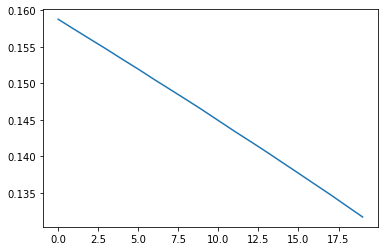

In [52]:
x=range(len(training_avg_loss))
plt.plot(x,training_avg_loss)

In [53]:
len(training_avg_loss)

20

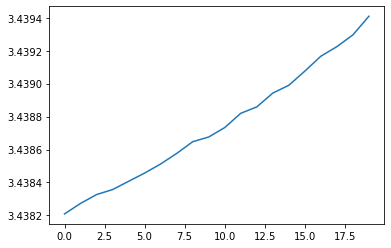

In [54]:
x=range(len(testing_avg_loss))
plt.plot(x,testing_avg_loss)

here
here1 28
batch size torch.Size([2, 3, 256, 256])
np  torch.Size([2, 31, 256, 256])
label size torch.Size([2, 256, 256])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
        

TypeError: Invalid shape (256, 256, 2) for image data

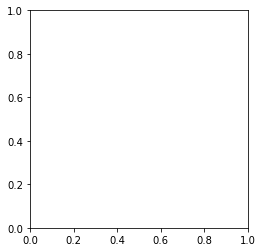

In [39]:

model.eval()
print("here")
with torch.set_grad_enabled(False):
    print("here1",len(test_gen))
    for batch,labels in test_gen:
#             print("here2")
        batch=batch.float()
        labels=labels.float()
#         labels = ((labels - labels.min()) * (1/(labels.max() - labels.min())*30))
        print("batch size", batch.size())
#             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#             print(batch,label)
        batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        predictions=model(batch)
#             print("predictions" ,predictions)
#             print("predictions size",predictions.size())
#             print("norm_pred",norm_pred.size())
#         npred = torch.argmax(predictions.squeeze(),dim=1)
        predictions = predictions.type(torch.FloatTensor)
        npred = torch.nn.functional.softmax(predictions,dim =1)
        print("np ", npred.size())
        labels = labels.squeeze(1)
        labels = labels.type(torch.LongTensor)
        print("label size", labels.size())
        print(labels)
        show(labels)
        pred_loss = lossfunc(npred,labels) 
        testing_loss.append(pred_loss)
#             print("pred_loss",pred_loss)
#         print("batch[0]",batch[0])
        masks = [
            npred[img_idx,sem_class_to_idx[cls]]
            for img_idx in range(batch.shape[0])
            for cls in classes]
        break


In [15]:
print("testing_total_loss",testing_loss)


testing_total_loss [tensor(3.4795)]


tensor([[0.0102, 0.0099, 0.0083,  ..., 0.0101, 0.0079, 0.0091],
        [0.0082, 0.0047, 0.0086,  ..., 0.0093, 0.0107, 0.0065],
        [0.0083, 0.0093, 0.0079,  ..., 0.0101, 0.0083, 0.0095],
        ...,
        [0.0090, 0.0049, 0.0076,  ..., 0.0038, 0.0086, 0.0077],
        [0.0065, 0.0088, 0.0085,  ..., 0.0076, 0.0077, 0.0077],
        [0.0090, 0.0072, 0.0082,  ..., 0.0071, 0.0099, 0.0079]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0.5344, 0.5830, 0.6431,  ..., 0.5975, 0.5960, 0.6170],
        [0.6560, 0.7495, 0.6169,  ..., 0.5872, 0.5427, 0.6109],
        [0.6344, 0.6469, 0.5166,  ..., 0.5496, 0.6270, 0.6222],
        ...,
        [0.6506, 0.6969, 0.6358,  ..., 0.7450, 0.6139, 0.5886],
        [0.6257, 0.6116, 0.5639,  ..., 0.6516, 0.6627, 0.6361],
        [0.6620

<ipython-input-37-54b9aea08a2b>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)


tensor([[0.0156, 0.0137, 0.0101,  ..., 0.0130, 0.0111, 0.0119],
        [0.0106, 0.0066, 0.0124,  ..., 0.0153, 0.0147, 0.0149],
        [0.0116, 0.0112, 0.0135,  ..., 0.0113, 0.0122, 0.0109],
        ...,
        [0.0110, 0.0117, 0.0122,  ..., 0.0077, 0.0137, 0.0144],
        [0.0129, 0.0127, 0.0137,  ..., 0.0118, 0.0107, 0.0112],
        [0.0113, 0.0096, 0.0102,  ..., 0.0112, 0.0125, 0.0143]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0.0142, 0.0145, 0.0155,  ..., 0.0153, 0.0139, 0.0140],
        [0.0150, 0.0113, 0.0148,  ..., 0.0145, 0.0194, 0.0120],
        [0.0144, 0.0113, 0.0152,  ..., 0.0185, 0.0128, 0.0138],
        ...,
        [0.0164, 0.0102, 0.0155,  ..., 0.0093, 0.0147, 0.0132],
        [0.0120, 0.0132, 0.0138,  ..., 0.0119, 0.0120, 0.0131],
        [0.0139

tensor([[0.0145, 0.0154, 0.0147,  ..., 0.0145, 0.0155, 0.0158],
        [0.0140, 0.0156, 0.0129,  ..., 0.0196, 0.0170, 0.0149],
        [0.0139, 0.0148, 0.0160,  ..., 0.0168, 0.0195, 0.0149],
        ...,
        [0.0150, 0.0120, 0.0175,  ..., 0.0086, 0.0216, 0.0184],
        [0.0136, 0.0125, 0.0172,  ..., 0.0130, 0.0162, 0.0152],
        [0.0179, 0.0149, 0.0206,  ..., 0.0137, 0.0190, 0.0148]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0.0146, 0.0110, 0.0114,  ..., 0.0145, 0.0140, 0.0138],
        [0.0105, 0.0090, 0.0154,  ..., 0.0139, 0.0089, 0.0182],
        [0.0104, 0.0137, 0.0167,  ..., 0.0139, 0.0201, 0.0119],
        ...,
        [0.0139, 0.0129, 0.0141,  ..., 0.0078, 0.0111, 0.0139],
        [0.0144, 0.0123, 0.0156,  ..., 0.0132, 0.0119, 0.0108],
        [0.0114

tensor([[0.0155, 0.0129, 0.0166,  ..., 0.0153, 0.0165, 0.0144],
        [0.0143, 0.0111, 0.0172,  ..., 0.0157, 0.0119, 0.0168],
        [0.0135, 0.0133, 0.0205,  ..., 0.0156, 0.0196, 0.0135],
        ...,
        [0.0131, 0.0110, 0.0126,  ..., 0.0082, 0.0139, 0.0159],
        [0.0131, 0.0135, 0.0173,  ..., 0.0138, 0.0147, 0.0144],
        [0.0123, 0.0174, 0.0145,  ..., 0.0157, 0.0139, 0.0155]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0.0124, 0.0124, 0.0117,  ..., 0.0142, 0.0135, 0.0151],
        [0.0105, 0.0076, 0.0197,  ..., 0.0167, 0.0105, 0.0117],
        [0.0095, 0.0098, 0.0177,  ..., 0.0137, 0.0159, 0.0114],
        ...,
        [0.0098, 0.0109, 0.0110,  ..., 0.0078, 0.0118, 0.0139],
        [0.0106, 0.0119, 0.0123,  ..., 0.0111, 0.0101, 0.0119],
        [0.0105

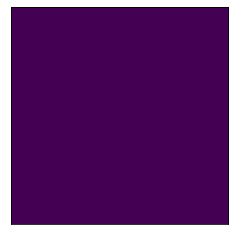

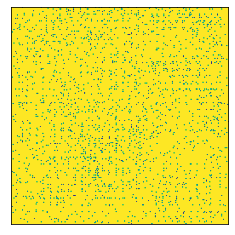

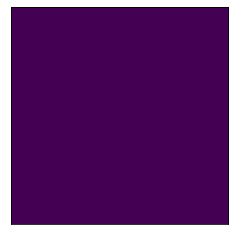

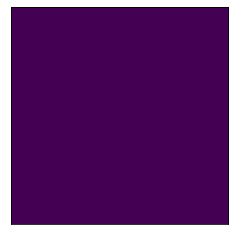

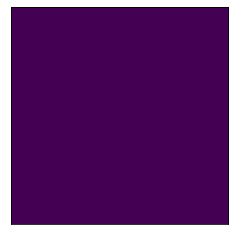

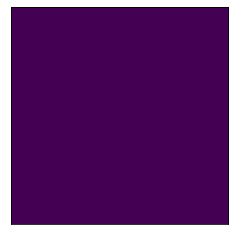

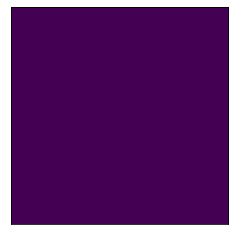

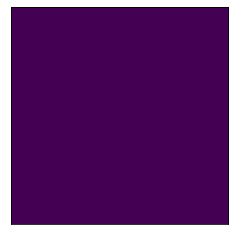

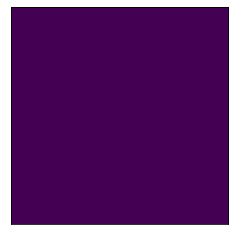

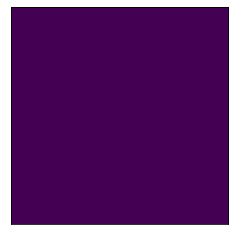

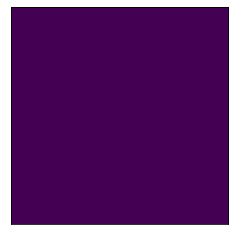

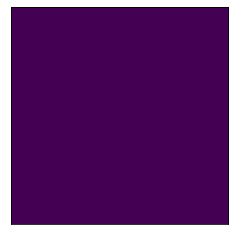

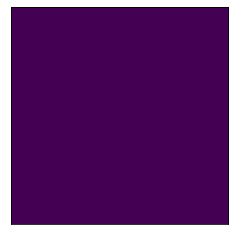

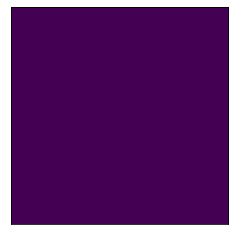

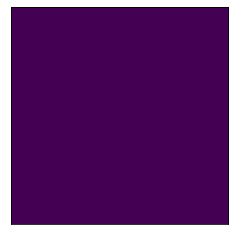

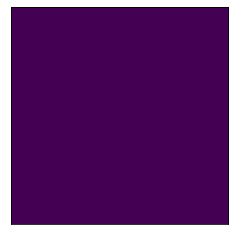

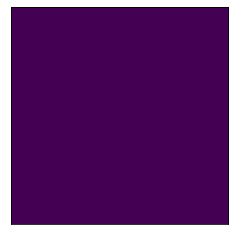

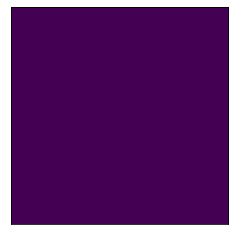

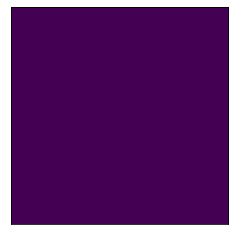

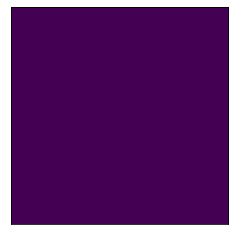

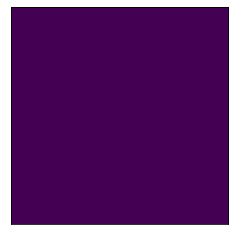

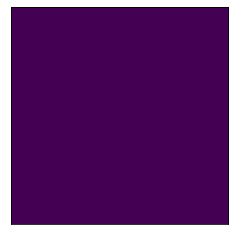

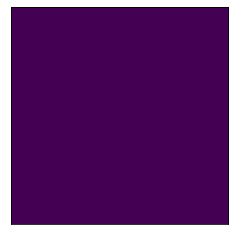

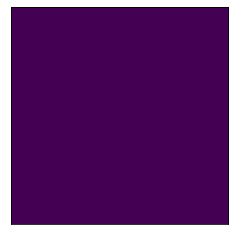

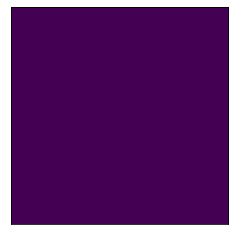

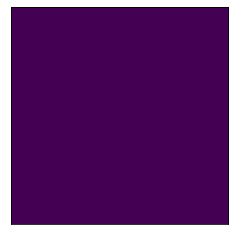

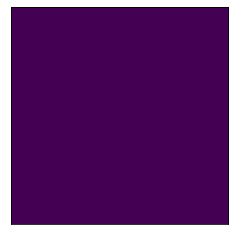

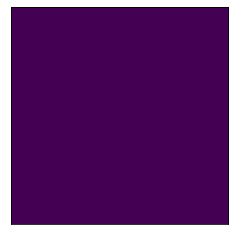

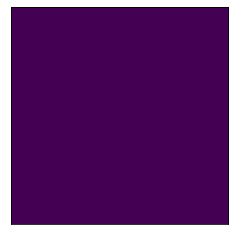

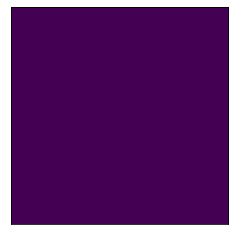

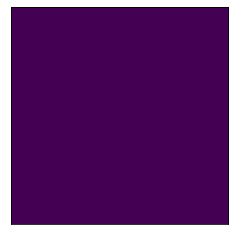

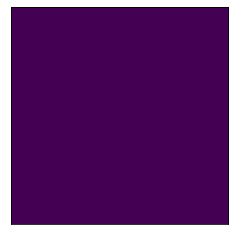

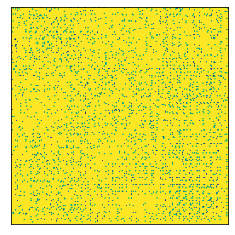

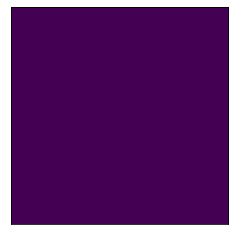

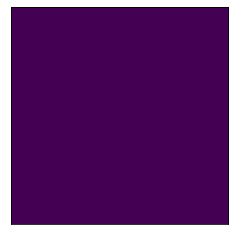

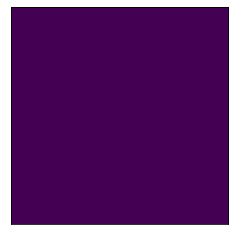

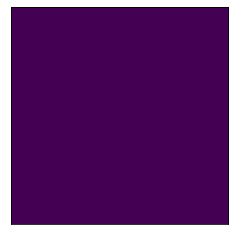

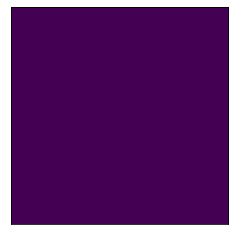

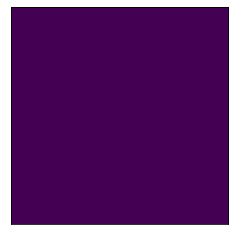

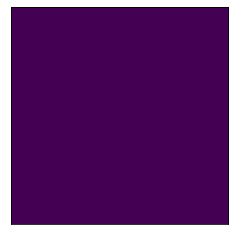

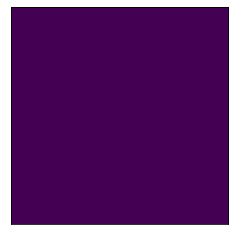

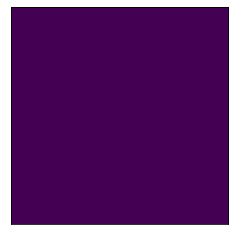

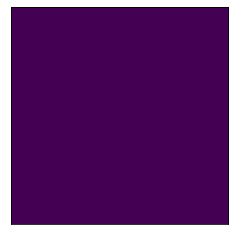

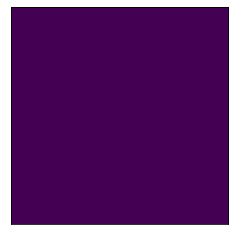

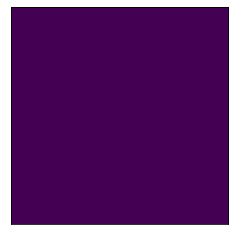

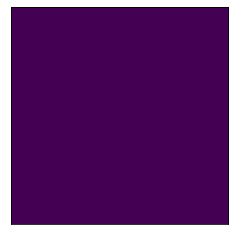

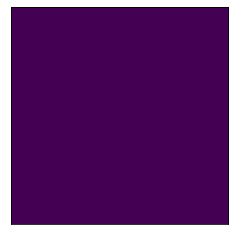

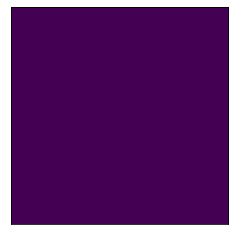

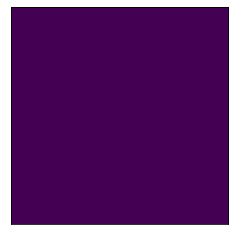

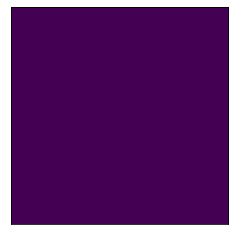

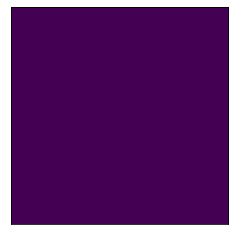

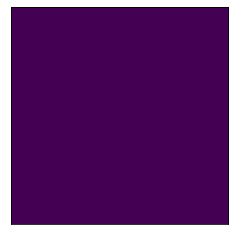

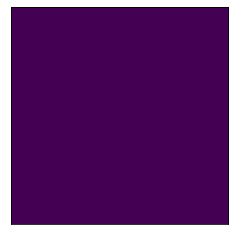

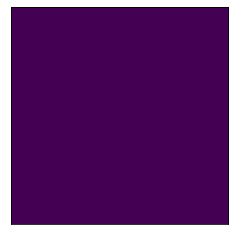

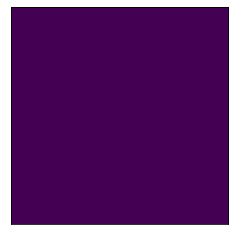

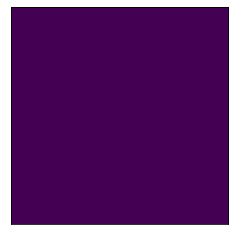

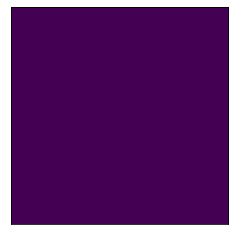

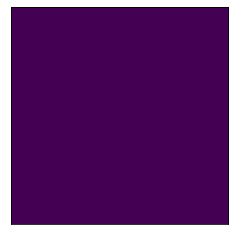

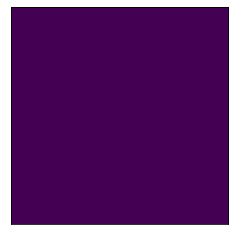

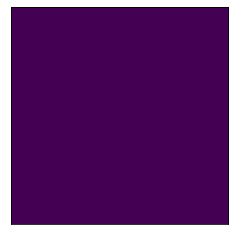

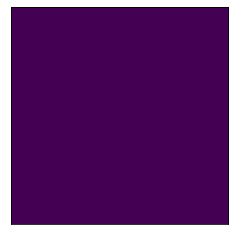

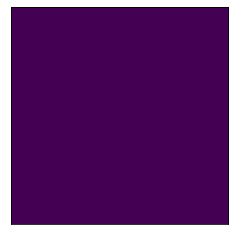

In [37]:

import matplotlib.pyplot as plt
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img2 = (img>0.5).float()
        print(img)
        print(img2)
        img = F.to_pil_image(img2)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
i = 0        
for mask in masks:
#     print(i)
    show(mask)
    i=i+1

In [113]:
# from PIL import Image
# import torchvision.transforms as T
# transform = T.ToPILImage(mode = np.dtype(float))
# img = npred
# # img = torch.argmax(npred.squeeze(),dim=1)
# print(img.size())
# print(img[0].max())
# image = transform(img[0])
# new_im = ((npred - npred.min()) * (1/(npred.max() - npred.min()) * 255))
# new_im.max()
# image = transform(new_im)

In [ ]:
# image

In [ ]:
transform = T.ToPILImage()
image = transform(batch[1])
image

In [ ]:
x

In [27]:
torch.save(model,'./tensor_model100.pt')